In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib
import matplotlib.pyplot as plt 
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import geopandas as gpd

matplotlib.rcParams['font.family'] = 'serif'


In [18]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
#world.to_crs(bodies_gdf.crs)
country_mask_world = ['Israel', 'Palestine', 'Jordan', 'Iraq', 'Syria', 'Turkey', 'Lebanon']
sub_world = world[world['name'].isin(country_mask_world)].copy()

In [19]:
cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))
cities = cities.set_crs(sub_world.crs)
sub_cities_list = list(cities.sjoin(sub_world, how = 'right')['name_left'])[1:]
sub_cities = cities[cities['name'].isin(sub_cities_list)]

In [24]:
data_dir = '/home/simon/Documents/Bodies/data/done_dfs/'

with open(f'{data_dir}bodies_df_2022_v1_2.pkl', 'rb') as file:
    bodies_df = pickle.load(file)

bodies_df = bodies_df[(bodies_df['distance_days'] == 0) | (bodies_df['location_annot'] == 1)] # only locations you are certain of

coords = gpd.GeoDataFrame(bodies_df[['longitude_full', 'latitude_full']], geometry=gpd.points_from_xy(bodies_df.longitude_full, bodies_df.latitude_full))
coords = coords.set_crs(sub_world.crs)
#coords = coords.to_crs(sub_world.crs)

bodies_df['coords'] = bodies_df['longitude_full'].astype("string") +'/'+ bodies_df['latitude_full'].astype("string")


In [31]:
print(coords['longitude_full'].unique())

print(coords['latitude_full'].unique())

[44.3787992  41.03786    41.046437   43.9        43.0997156  43.688611
 43.101652   44.3299926  43.453298   44.4328131  44.3953896  43.733333
 44.1463366  44.1749775  43.7875674  43.2999218  44.6495225  47.8090981
 43.8196617  43.18453419 44.2474609  43.795799   45.42941229 42.1894609
 44.2774643  44.15278864 38.9796397  35.0284908  42.70078692 42.4570311
 42.56851022 38.06999189 43.6005196 ]
[33.3024309  34.427567   34.390889   34.2        36.34369405 33.278889
 35.081981   32.0010227  33.420684   32.482245   35.4719308  34.533333
 33.3045249  33.0955793  33.3532137  33.4259859  33.7437267  30.4952371
 32.4511703  36.5087974  33.8370695  34.4583493  31.33095615 37.3274814
 33.5298923  34.00131295 32.7265004  31.5967865  37.1543002  37.5219577
 37.14992005 36.0792774  33.33220675]


In [33]:
coords['longitude_full'].unique().shape

(33,)

In [25]:
bodies_df.shape

(115265, 177)

Add male and persons - make more metainable.

# In Space:

In [5]:
def get_coords_gpd( feature, bodies_df = bodies_df, sub_world = sub_world):

    if feature == None:
        unique_coords = bodies_df.groupby('coords').count()

    else:
        unique_coords = bodies_df[bodies_df[feature] >= 1].groupby('coords').count()
    
    unique_coords = unique_coords['person_mean'].reset_index() # the feature does not matter here
    unique_coords.rename(columns={'person_mean' : 'images'}, inplace= True)

    unique_coords['l_img'] = np.log(unique_coords['images']) # why?

    unique_coords['longitude_full'] = unique_coords['coords'].str.split('/', expand = True).loc[:,0]
    unique_coords['latitude_full'] = unique_coords['coords'].str.split('/', expand = True).loc[:,1]
    unique_coords.drop('coords', axis=1, inplace=True)

    coords = gpd.GeoDataFrame(unique_coords, geometry=gpd.points_from_xy(unique_coords.longitude_full, unique_coords.latitude_full))
    coords = coords.set_crs(sub_world.crs)

    return coords

In [6]:
coords = get_coords_gpd(None)
coords_per = get_coords_gpd('person_mean')
coords_fem = get_coords_gpd('female_mean')
coords_gar = get_coords_gpd('religiousGarmentFemale_mean')
coords_uni = get_coords_gpd('uniformed_mean')
coords_fir = get_coords_gpd('firearm_mean')

In [7]:
coords_mil = get_coords_gpd('all_militarized')
coords_dam = get_coords_gpd('damaged_property')
coords_pro = get_coords_gpd('mass_protest')

coords_pri = get_coords_gpd('all_privat')
coords_pub = get_coords_gpd('all_public')

coords_urb = get_coords_gpd('all_urban')
coords_rur = get_coords_gpd('all_rural')

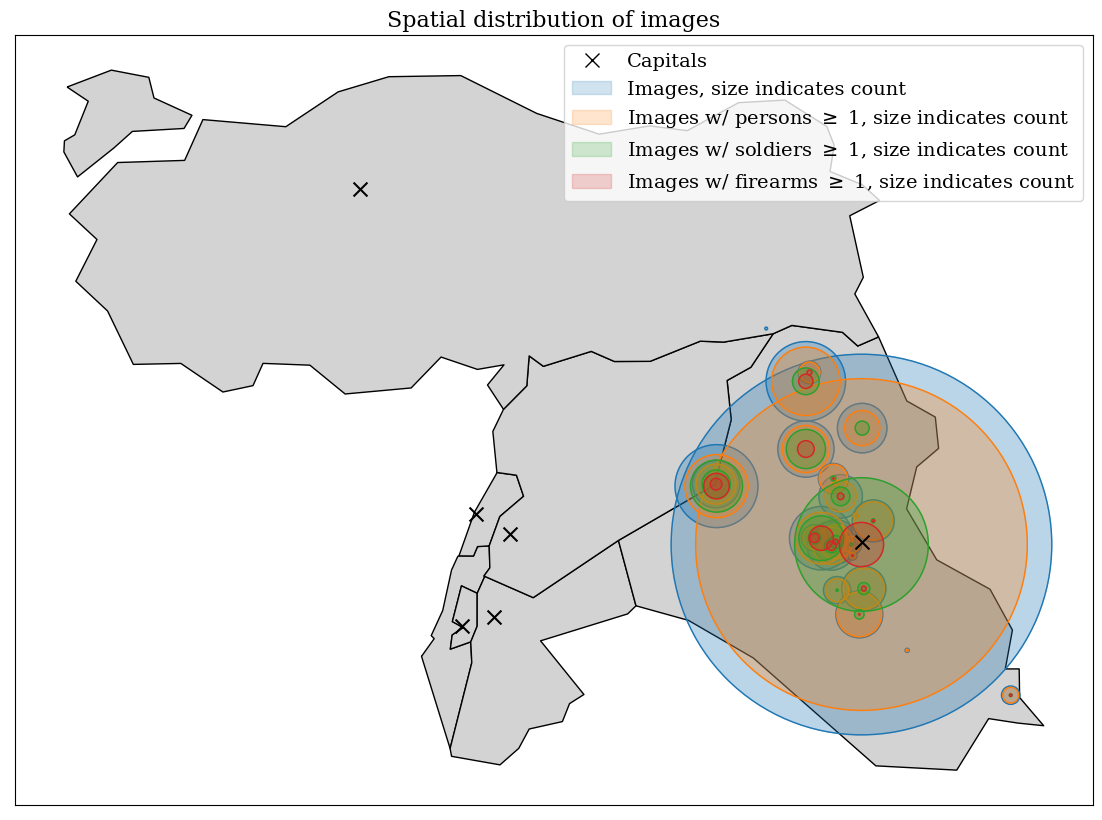

In [8]:
ax = sub_world.plot(edgecolors = 'black', color = 'lightgray', figsize=(15, 10), label = 'Capitals')

coords.plot(ax=ax, color='C0', marker='o', markersize = coords['images'], fc = 'none')
coords.plot(ax=ax, color='C0', marker='o', markersize = coords['images'], alpha = 0.3)

coords_per.plot(ax=ax, color='C1', marker='o', markersize = coords_per['images'], fc = 'none')
coords_per.plot(ax=ax, color='C1', marker='o', markersize = coords_per['images'], alpha = 0.3)

coords_uni.plot(ax=ax, color='C2', marker='o', markersize = coords_uni['images'], fc = 'none')
coords_uni.plot(ax=ax, color='C2', marker='o', markersize = coords_uni['images'], alpha = 0.3)

coords_fir.plot(ax=ax, color='C3', marker='o', markersize = coords_fir['images'], fc = 'none')
coords_fir.plot(ax=ax, color='C3', marker='o', markersize = coords_fir['images'], alpha = 0.3)

sub_cities.plot(ax=ax, color='black', marker='x', markersize = 100)

plt.title('Spatial distribution of images', fontsize = 16)

plt.xticks([])
plt.yticks([])

leg_cap = mlines.Line2D([], [], color='none', markeredgecolor='Black', marker='x', markersize=10, label='Capitals')

leg_images = mpatches.Patch(color='C0', label='Images, size indicates count', alpha = 0.2)
leg_per = mpatches.Patch(color='C1', label='Images w/ persons $\geq$ 1, size indicates count', alpha = 0.2)
leg_uni = mpatches.Patch(color='C2', label='Images w/ soldiers $\geq$ 1, size indicates count', alpha = 0.2)
leg_fir = mpatches.Patch(color='C3', label='Images w/ firearms $\geq$ 1, size indicates count', alpha = 0.2)


ax.legend(handles=[leg_cap, leg_images, leg_per, leg_uni, leg_fir], fontsize = 14)

fig_path = f'/home/simon/Documents/Bodies/figures/maps/introducing/map1.png'
plt.savefig(fig_path, bbox_inches="tight")

plt.show()

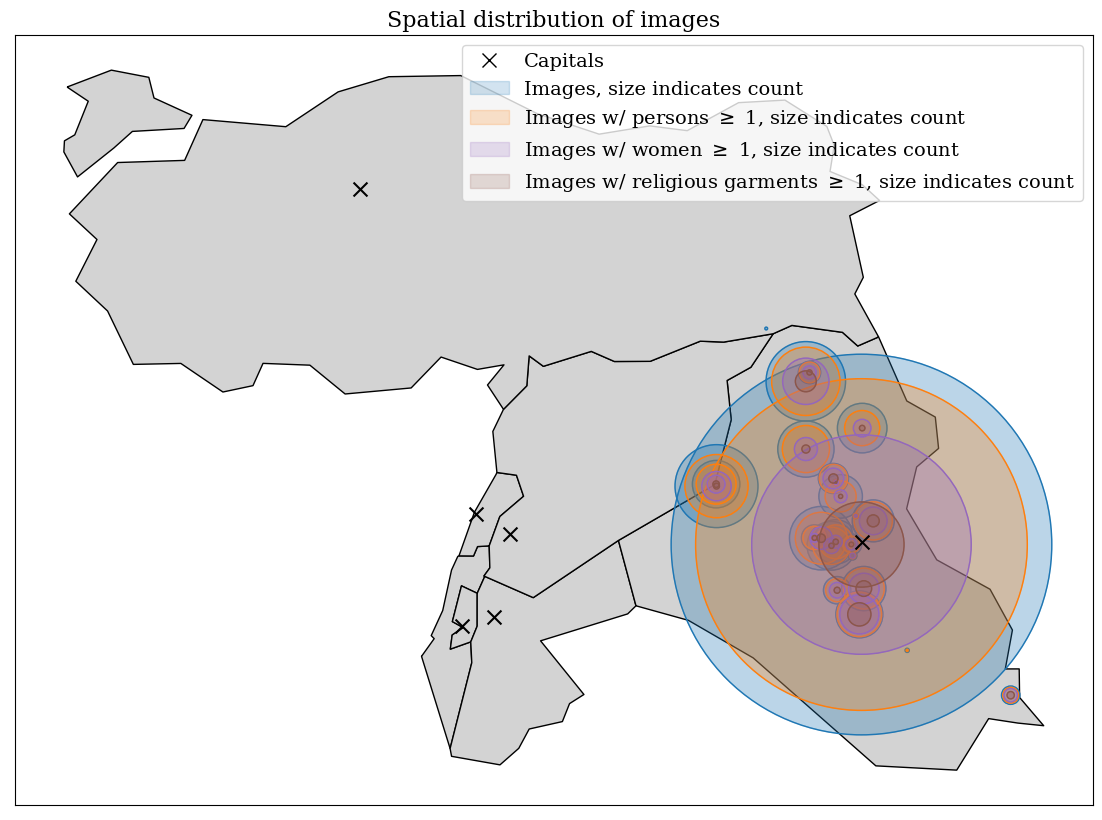

In [9]:
ax = sub_world.plot(edgecolors = 'black', color = 'lightgray', figsize=(15, 10), label = 'Capitals')

coords.plot(ax=ax, color='C0', marker='o', markersize = coords['images'], fc = 'none')
coords.plot(ax=ax, color='C0', marker='o', markersize = coords['images'], alpha = 0.3)

coords_per.plot(ax=ax, color='C1', marker='o', markersize = coords_per['images'], fc = 'none')
coords_per.plot(ax=ax, color='C1', marker='o', markersize = coords_per['images'], alpha = 0.3)

coords_fem.plot(ax=ax, color='C4', marker='o', markersize = coords_fem['images'], fc = 'none')
coords_fem.plot(ax=ax, color='C4', marker='o', markersize = coords_fem['images'], alpha = 0.3)

coords_gar.plot(ax=ax, color='C5', marker='o', markersize = coords_gar['images'], fc = 'none')
coords_gar.plot(ax=ax, color='C5', marker='o', markersize = coords_gar['images'], alpha = 0.3)

sub_cities.plot(ax=ax, color='black', marker='x', markersize = 100)

plt.title('Spatial distribution of images', fontsize = 16)

plt.xticks([])
plt.yticks([])

leg_cap = mlines.Line2D([], [], color='none', markeredgecolor='Black', marker='x', markersize=10, label='Capitals')

leg_images = mpatches.Patch(color='C0', label='Images, size indicates count', alpha = 0.2)
leg_per = mpatches.Patch(color='C1', label='Images w/ persons $\geq$ 1, size indicates count', alpha = 0.2)
leg_fam = mpatches.Patch(color='C4', label='Images w/ women $\geq$ 1, size indicates count', alpha = 0.2)
leg_gar = mpatches.Patch(color='C5', label='Images w/ religious garments $\geq$ 1, size indicates count', alpha = 0.2)


ax.legend(handles=[leg_cap, leg_images, leg_per, leg_fam, leg_gar], fontsize = 14)

fig_path = f'/home/simon/Documents/Bodies/figures/maps/introducing/map2.png'
plt.savefig(fig_path, bbox_inches="tight")

plt.show()

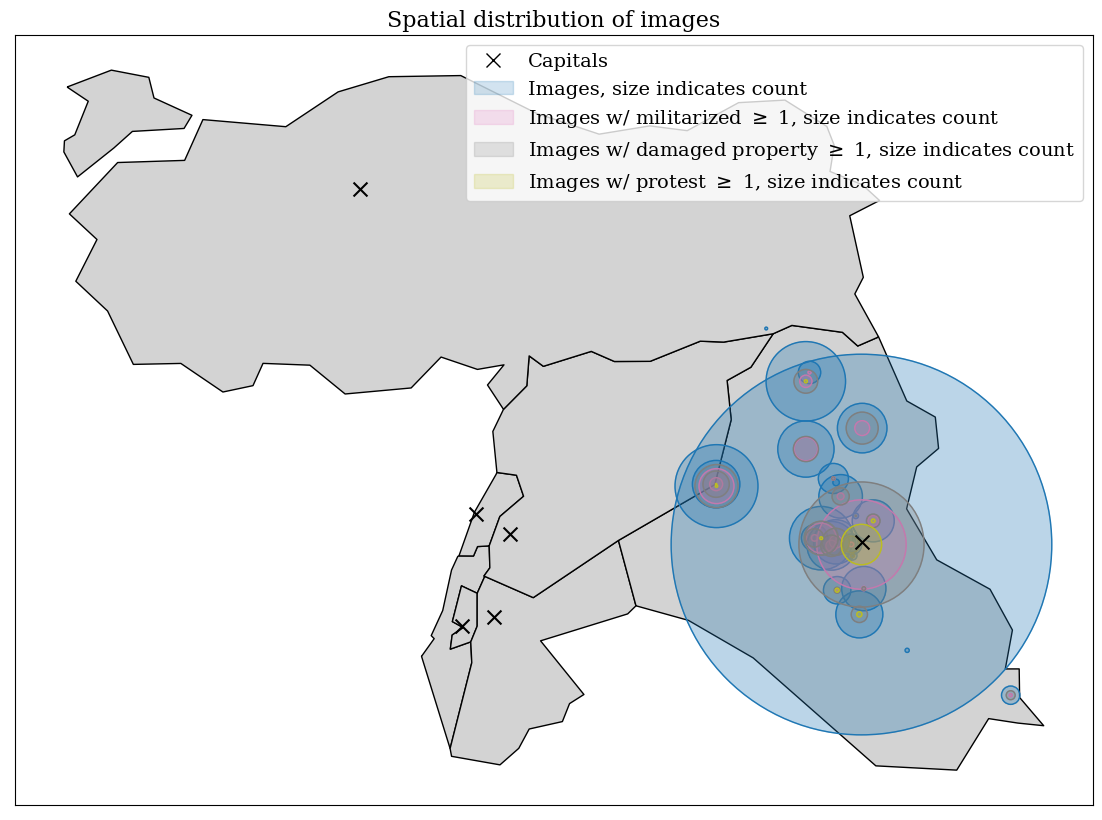

In [10]:
ax = sub_world.plot(edgecolors = 'black', color = 'lightgray', figsize=(15, 10), label = 'Capitals')

coords.plot(ax=ax, color='C0', marker='o', markersize = coords['images'], fc = 'none')
coords.plot(ax=ax, color='C0', marker='o', markersize = coords['images'], alpha = 0.3)

coords_mil.plot(ax=ax, color='C6', marker='o', markersize = coords_mil['images'], fc = 'none')
coords_mil.plot(ax=ax, color='C6', marker='o', markersize = coords_mil['images'], alpha = 0.3)

coords_dam.plot(ax=ax, color='C7', marker='o', markersize = coords_dam['images'], fc = 'none')
coords_dam.plot(ax=ax, color='C7', marker='o', markersize = coords_dam['images'], alpha = 0.3)

coords_pro.plot(ax=ax, color='C8', marker='o', markersize = coords_pro['images'], fc = 'none')
coords_pro.plot(ax=ax, color='C8', marker='o', markersize = coords_pro['images'], alpha = 0.3)

sub_cities.plot(ax=ax, color='black', marker='x', markersize = 100)

plt.title('Spatial distribution of images', fontsize = 16)

plt.xticks([])
plt.yticks([])

leg_cap = mlines.Line2D([], [], color='none', markeredgecolor='Black', marker='x', markersize=10, label='Capitals')

leg_images = mpatches.Patch(color='C0', label='Images, size indicates count', alpha = 0.2)
leg_mil = mpatches.Patch(color='C6', label='Images w/ militarized $\geq$ 1, size indicates count', alpha = 0.2)
leg_dam = mpatches.Patch(color='C7', label='Images w/ damaged property $\geq$ 1, size indicates count', alpha = 0.2)
leg_pro = mpatches.Patch(color='C8', label='Images w/ protest $\geq$ 1, size indicates count', alpha = 0.2)


ax.legend(handles=[leg_cap, leg_images, leg_mil, leg_dam, leg_pro], fontsize = 14)

fig_path = f'/home/simon/Documents/Bodies/figures/maps/introducing/map3.png'
plt.savefig(fig_path, bbox_inches="tight")

plt.show()

In [26]:
bodies_df.groupby('city').count().sort_values('person_mean')

,person_mean,person_median,person_fasterR50,person_fasterR101,person_fasterX101,person_retinaR50,person_retinaR101,child_mean,child_median,child_retinaR50,...,emotions_t1,emotions_t2,all_formal,all_public,all_militarized,all_urban,damaged_property,mass_protest,all_privat,coords
city,,,,,,,,,,,,,,,,,,,,,
Falluja,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Habur Port,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
cizre,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Al-Samawa,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Sirnak,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
Cizre,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
Zaxo,9,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
Baqouba,9,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
Kara-Ula,11,11,11,11,11,11,11,11,11,11,...,11,11,11,11,11,11,11,11,11,11


In [ ]:
Ad Dawr

In [41]:
for i in bodies_df.columns:
    print(i)

person_mean
person_median
person_fasterR50
person_fasterR101
person_fasterX101
person_retinaR50
person_retinaR101
child_mean
child_median
child_retinaR50
child_retinaR101
male_mean
male_median
male_fasterR50
male_fasterR101
male_fasterX101
male_retinaR50
male_retinaR101
adult_mean
adult_median
adult_fasterR50
adult_fasterR101
adult_fasterX101
adult_retinaR50
adult_retinaR101
youth_mean
youth_median
youth_retinaR50
youth_retinaR101
falgIRQ_mean
falgIRQ_median
falgIRQ_fasterR50
falgIRQ_fasterR101
falgIRQ_fasterX101
falgIRQ_retinaR50
falgIRQ_retinaR101
female_mean
female_median
female_retinaR50
female_retinaR101
religiousGarmentFemale_mean
religiousGarmentFemale_median
religiousGarmentFemale_retinaR50
religiousGarmentFemale_retinaR101
uniformed_mean
uniformed_median
uniformed_fasterR50
uniformed_fasterR101
uniformed_fasterX101
uniformed_retinaR50
uniformed_retinaR101
firearm_mean
firearm_median
firearm_fasterR50
firearm_fasterR101
firearm_fasterX101
firearm_retinaR50
firearm_retinaR101
fl

In [10]:
coords.rename(columns = {'images' : 'img_all', 'l_img' : 'l_img_all'}, inplace = True)
coords_fem.rename(columns = {'images' : 'img_fem', 'l_img' : 'l_img_fem'}, inplace = True)
coords_gar.rename(columns = {'images' : 'img_gar', 'l_img' : 'l_img_gar'}, inplace = True)
coords_uni.rename(columns = {'images' : 'img_uni', 'l_img' : 'l_img_uni'}, inplace = True)


coord_merge = coords.merge(coords_fem, how = 'outer', on = ['longitude_full', 'latitude_full', 'geometry'])
coord_merge = coord_merge.merge(coords_gar, how = 'outer', on = ['longitude_full', 'latitude_full', 'geometry'])
coord_merge = coord_merge.merge(coords_uni, how = 'outer', on = ['longitude_full', 'latitude_full', 'geometry'])

coord_merge.fillna(0, inplace = True)

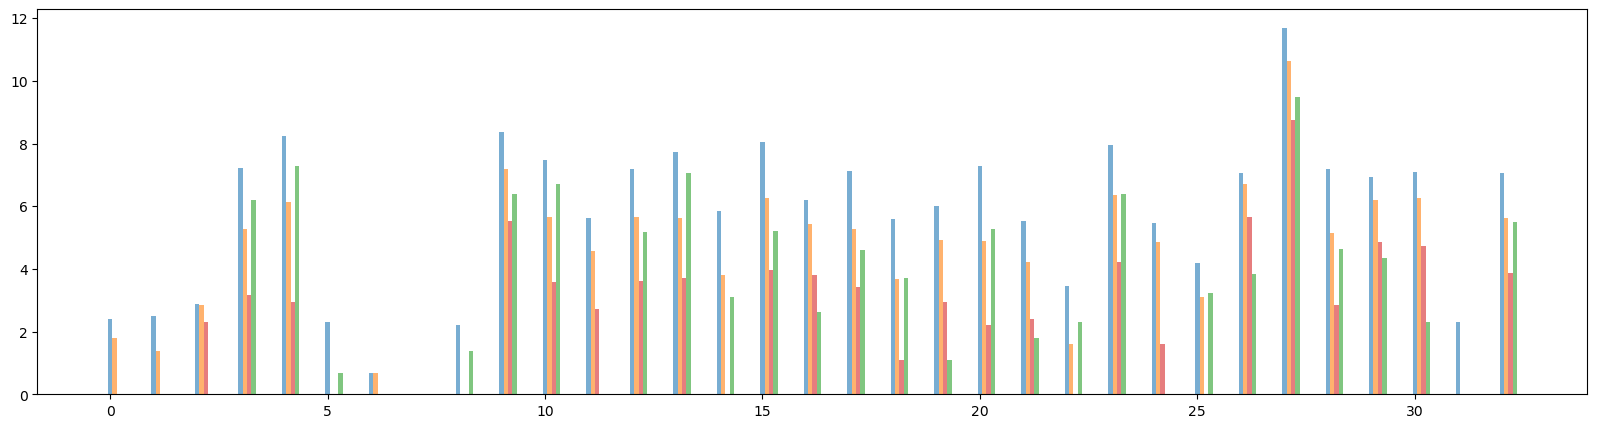

In [11]:
plt.figure(figsize=[20,5])

plt.bar(np.array(list(coord_merge.index)), coord_merge['l_img_all'], color ='C0', width = 0.1, alpha = 0.6)
plt.bar(np.array(list(coord_merge.index))+.1, coord_merge['l_img_fem'], color ='C1', width = 0.1, alpha = 0.6)
plt.bar(np.array(list(coord_merge.index))+.2, coord_merge['l_img_gar'], color ='C3', width = 0.1, alpha = 0.6)
plt.bar(np.array(list(coord_merge.index))+.3, coord_merge['l_img_uni'], color ='C2', width = 0.1, alpha = 0.6)

plt.show()

tjek if this the places with no women are bases. ANd what about the one with same amount of women an persons?

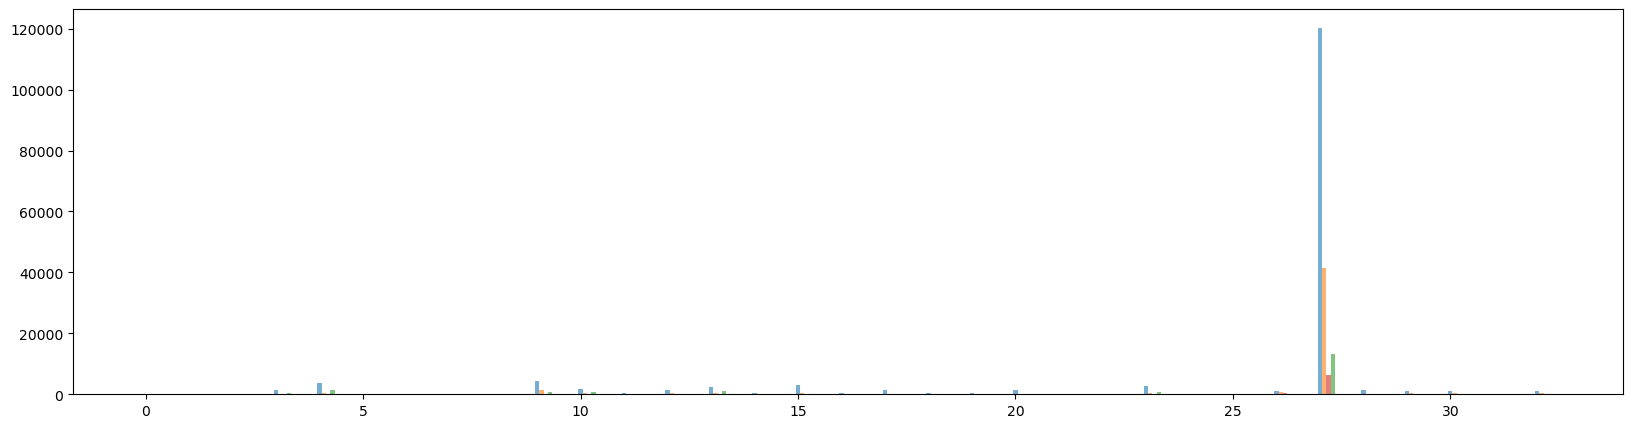

In [12]:
plt.figure(figsize=[20,5])

plt.bar(np.array(list(coord_merge.index)), coord_merge['img_all'], color ='C0', width = 0.1, alpha = 0.6)
plt.bar(np.array(list(coord_merge.index))+.1, coord_merge['img_fem'], color ='C1', width = 0.1, alpha = 0.6)
plt.bar(np.array(list(coord_merge.index))+.2, coord_merge['img_gar'], color ='C3', width = 0.1, alpha = 0.6)
plt.bar(np.array(list(coord_merge.index))+.3, coord_merge['img_uni'], color ='C2', width = 0.1, alpha = 0.6)

plt.show()

# In time

In [48]:
unique_months = bodies_df.groupby('month_id').count() # the feature does not matter here
unique_months = unique_months['person_mean'].reset_index()
unique_months.rename(columns={'person_mean' : 'images'}, inplace= True)

unique_months_per = bodies_df[bodies_df['person_mean'] >= 1].groupby('month_id').count() # the feature does not matter here
unique_months_per = unique_months_per['person_mean'].reset_index()
unique_months_per.rename(columns={'person_mean' : 'images'}, inplace= True)

unique_months_mal = bodies_df[bodies_df['male_mean'] >= 1].groupby('month_id').count() # the feature does not matter here
unique_months_mal = unique_months_mal['person_mean'].reset_index()
unique_months_mal.rename(columns={'person_mean' : 'images'}, inplace= True)

unique_months_fem = bodies_df[bodies_df['female_mean'] >= 1].groupby('month_id').count() # the feature does not matter here
unique_months_fem = unique_months_fem['person_mean'].reset_index()
unique_months_fem.rename(columns={'person_mean' : 'images'}, inplace= True)

unique_months_gar = bodies_df[bodies_df['religiousGarmentFemale_mean'] >= 1].groupby('month_id').count() # the feature does not matter here
unique_months_gar = unique_months_gar['person_mean'].reset_index()
unique_months_gar.rename(columns={'person_mean' : 'images'}, inplace= True)


unique_months_uni = bodies_df[bodies_df['uniformed_mean'] >= 1].groupby('month_id').count() # the feature does not matter here
unique_months_uni = unique_months_uni['person_mean'].reset_index()
unique_months_uni.rename(columns={'person_mean' : 'images'}, inplace= True)



unique_months.rename(columns = {'images' : 'img_all', 'l_img' : 'l_img_all'}, inplace = True)
unique_months_per.rename(columns = {'images' : 'img_per', 'l_img' : 'l_img_per'}, inplace = True)
unique_months_mal.rename(columns = {'images' : 'img_mal', 'l_img' : 'l_img_mal'}, inplace = True)
unique_months_fem.rename(columns = {'images' : 'img_fem', 'l_img' : 'l_img_fem'}, inplace = True)
unique_months_gar.rename(columns = {'images' : 'img_gar', 'l_img' : 'l_img_gar'}, inplace = True)
unique_months_uni.rename(columns = {'images' : 'img_uni', 'l_img' : 'l_img_uni'}, inplace = True)

months_merge = unique_months.merge(unique_months_per, how = 'outer', on = ['month_id'])
months_merge = months_merge.merge(unique_months_mal, how = 'outer', on = ['month_id'])
months_merge = months_merge.merge(unique_months_fem, how = 'outer', on = ['month_id'])
months_merge = months_merge.merge(unique_months_gar, how = 'outer', on = ['month_id'])
months_merge = months_merge.merge(unique_months_uni, how = 'outer', on = ['month_id'])

months_merge.fillna(0, inplace = True)

months_merge['per_ratio'] = months_merge['img_per']/months_merge['img_all']
months_merge['mal_ratio'] = months_merge['img_mal']/months_merge['img_all']
months_merge['fem_ratio'] = months_merge['img_fem']/months_merge['img_all']
months_merge['gar_ratio'] = months_merge['img_gar']/months_merge['img_all']
months_merge['uni_ratio'] = months_merge['img_uni']/months_merge['img_all']


months_merge['mal_per_ratio'] = (months_merge['img_mal']+1)/(months_merge['img_per']+1)
months_merge['fem_per_ratio'] = (months_merge['img_fem']+1)/(months_merge['img_per']+1)
months_merge['gar_per_ratio'] = (months_merge['img_gar']+1)/(months_merge['img_per']+1)
months_merge['uni_per_ratio'] = (months_merge['img_uni']+1)/(months_merge['img_per']+1)

months_merge['uni_mal_ratio'] = (months_merge['img_uni']+1)/(months_merge['img_mal']+1)
months_merge['uni_fem_ratio'] = (months_merge['img_uni']+1)/(months_merge['img_fem']+1)

months_merge['fem_gar_ratio'] = (months_merge['img_gar']+1)/(months_merge['img_fem']+1)


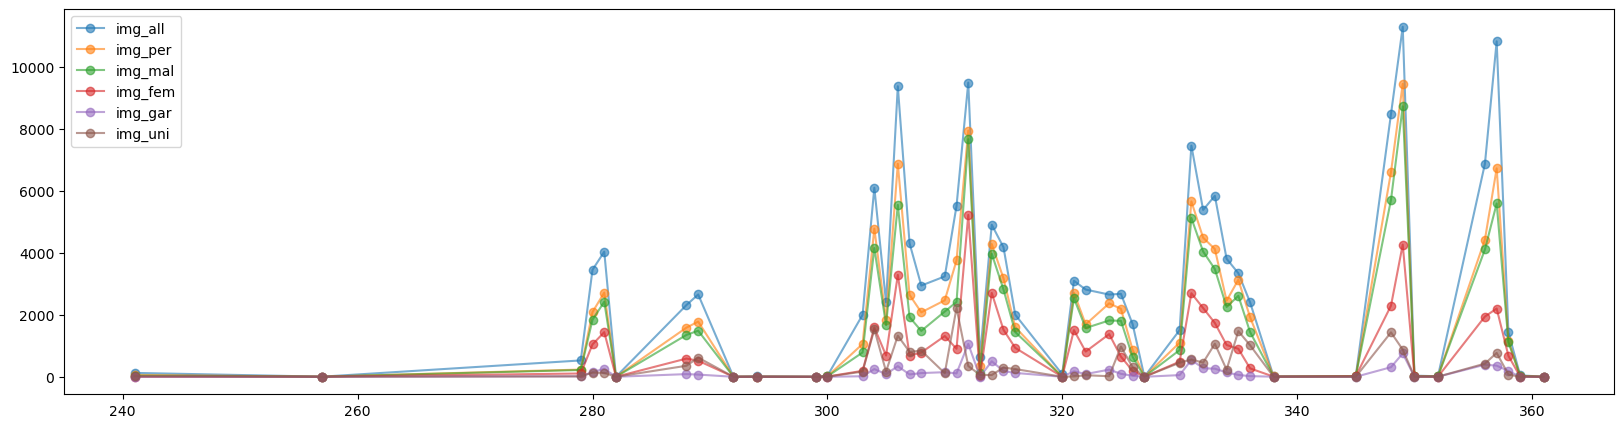

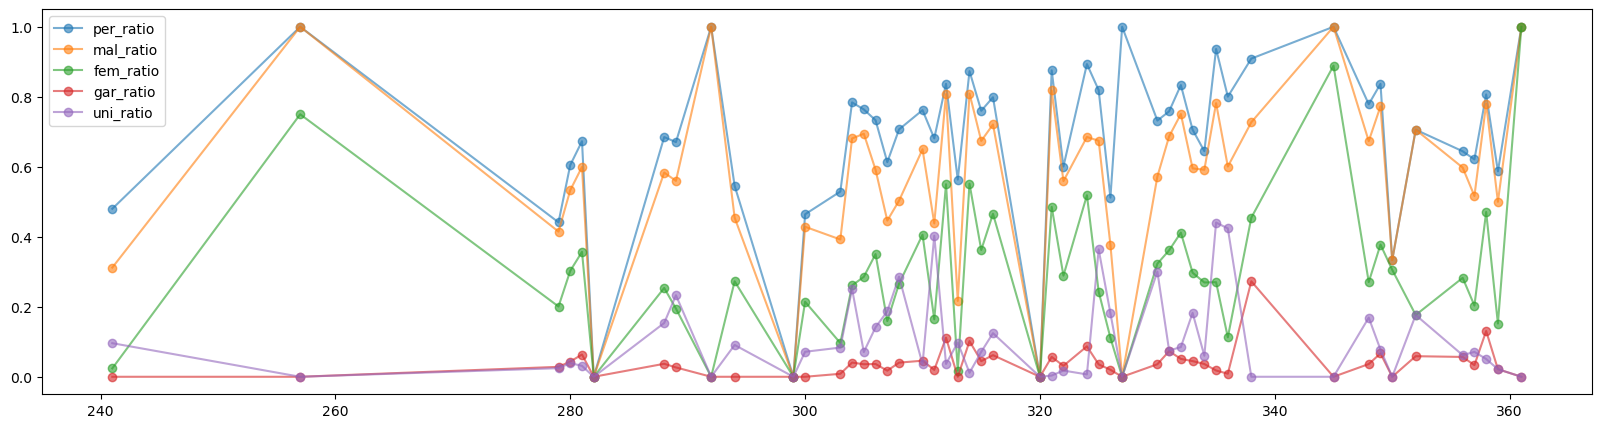

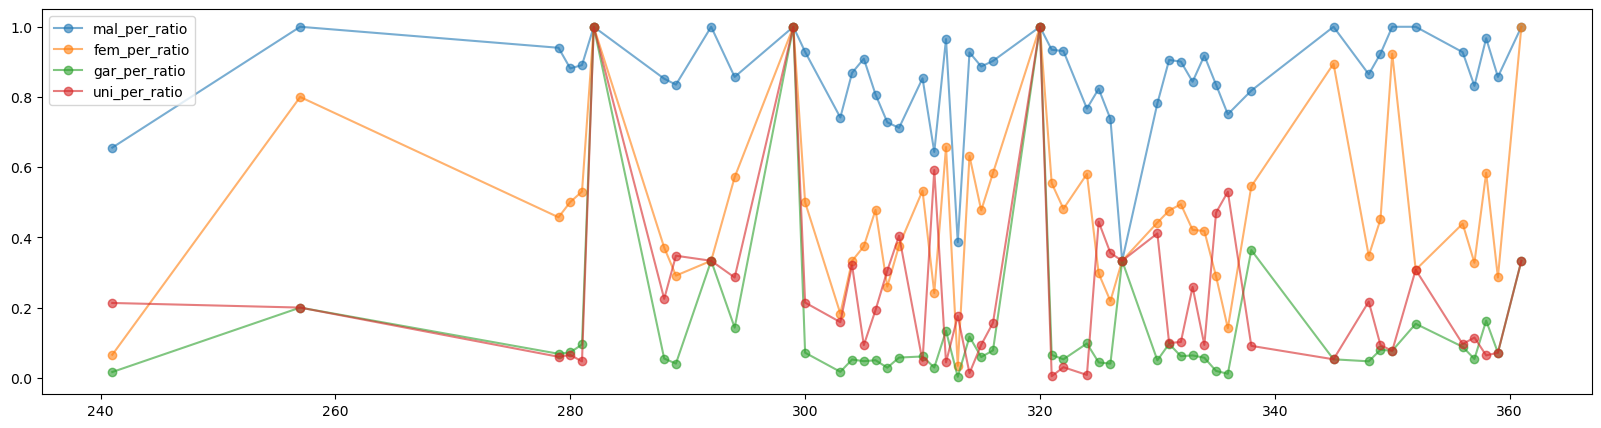

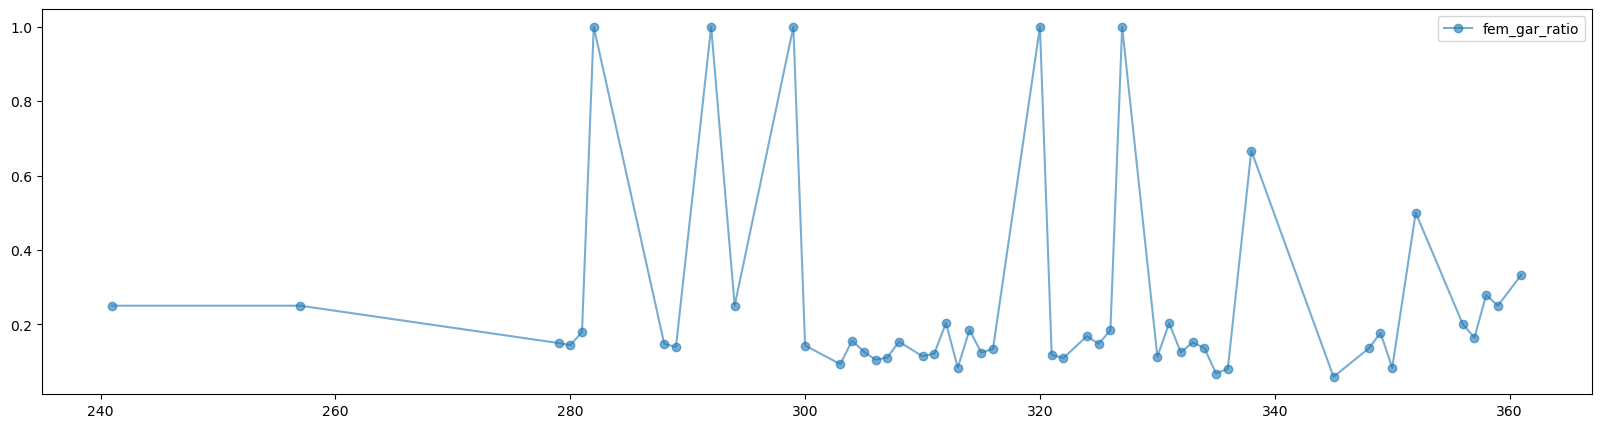

In [50]:
plt.figure(figsize=[20,5])

for i in ['img_all', 'img_per', 'img_mal', 'img_fem', 'img_gar', 'img_uni']:
    plt.plot(months_merge['month_id'], months_merge[i], '-o', alpha = 0.6, label = i) # , color = 'C0'

plt.legend()
plt.show()


plt.figure(figsize=[20,5])

for i in ['per_ratio', 'mal_ratio', 'fem_ratio', 'gar_ratio', 'uni_ratio']:
    plt.plot(months_merge['month_id'], months_merge[i], '-o', alpha = 0.6, label = i) # , color = 'C0'

plt.legend()
plt.show()


plt.figure(figsize=[20,5])

for i in ['mal_per_ratio', 'fem_per_ratio', 'gar_per_ratio', 'uni_per_ratio']:
    plt.plot(months_merge['month_id'], months_merge[i], '-o', alpha = 0.6, label = i) # , color = 'C0'

plt.legend()
plt.show()


# plt.figure(figsize=[20,5])

# for i in ['uni_mal_ratio', 'uni_fem_ratio']:
#     plt.plot(months_merge['month_id'], months_merge[i], '-o', alpha = 0.6, label = i) # , color = 'C0'

# plt.legend()
# plt.show()



plt.figure(figsize=[20,5])

plt.plot(months_merge['month_id'], months_merge['fem_gar_ratio'], '-o', alpha = 0.6, label = 'fem_gar_ratio') # , color = 'C0'

plt.legend()
plt.show()

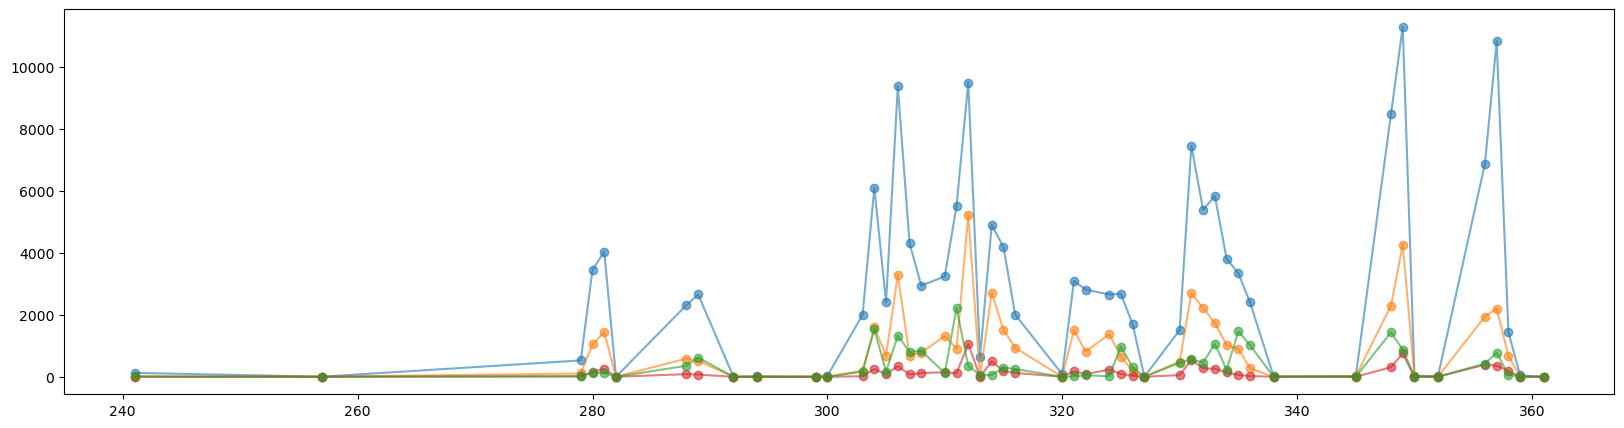

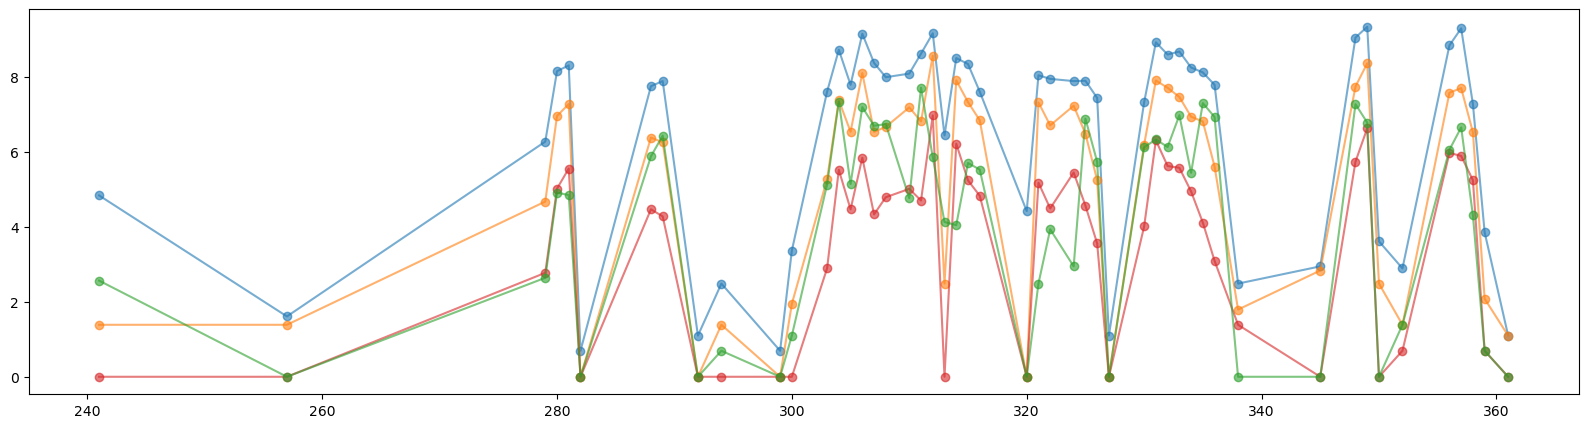

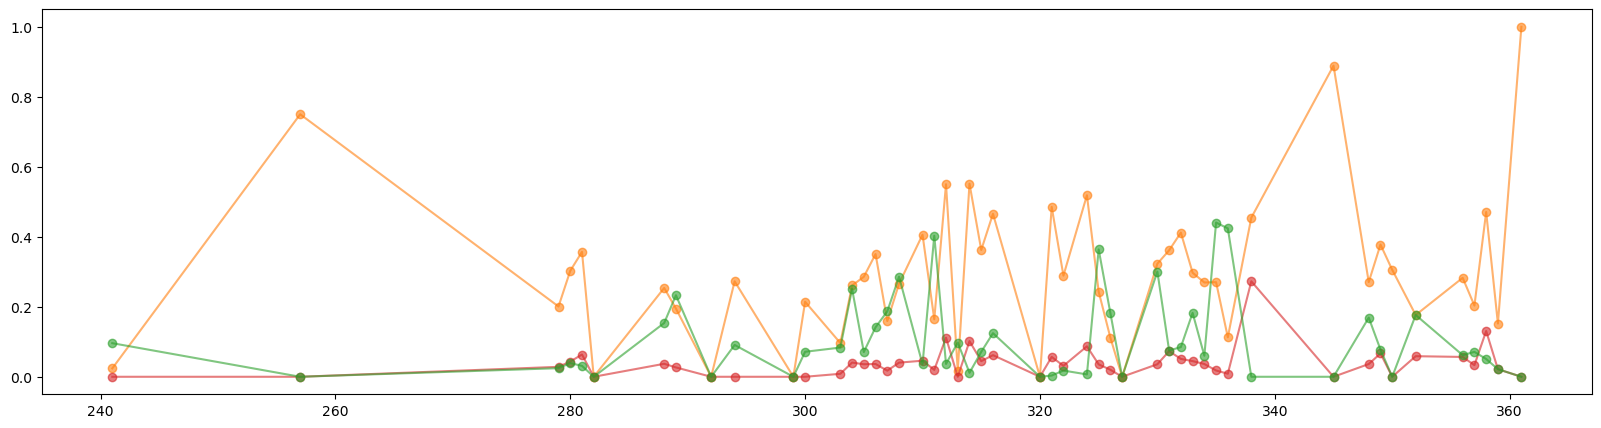

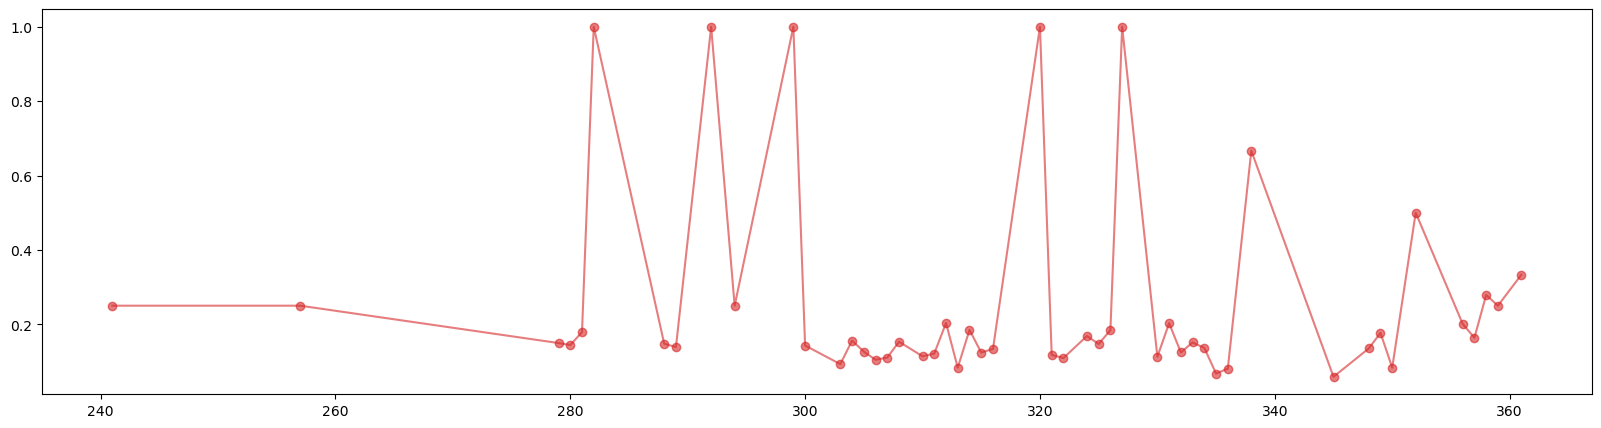

In [27]:
plt.figure(figsize=[20,5])

plt.plot(months_merge['month_id'], months_merge['img_all'], '-o', color = 'C0', alpha = 0.6, label = '')
plt.plot(months_merge['month_id'], months_merge['img_fem'], '-o', color = 'C1', alpha = 0.6)
plt.plot(months_merge['month_id'], months_merge['img_gar'], '-o', color = 'C3', alpha = 0.6)
plt.plot(months_merge['month_id'], months_merge['img_uni'], '-o', color = 'C2', alpha = 0.6)

plt.show()




plt.figure(figsize=[20,5])

plt.plot(months_merge['month_id'], np.log(months_merge['img_all']+1), '-o', color = 'C0', alpha = 0.6)
plt.plot(months_merge['month_id'], np.log(months_merge['img_fem']+1), '-o', color = 'C1', alpha = 0.6)
plt.plot(months_merge['month_id'], np.log(months_merge['img_gar']+1), '-o', color = 'C3', alpha = 0.6)
plt.plot(months_merge['month_id'], np.log(months_merge['img_uni']+1), '-o', color = 'C2', alpha = 0.6)

plt.show()





plt.figure(figsize=[20,5])

plt.plot(months_merge['month_id'], months_merge['fem_ratio'], '-o', color = 'C1', alpha = 0.6)
plt.plot(months_merge['month_id'], months_merge['gar_ratio'], '-o', color = 'C3', alpha = 0.6)
plt.plot(months_merge['month_id'], months_merge['uni_ratio'], '-o', color = 'C2', alpha = 0.6)

plt.show()



plt.figure(figsize=[20,5])
plt.plot(months_merge['month_id'], months_merge['fem_gar_ratio'], '-o', color = 'C3', alpha = 0.6)

plt.show()

In [ ]:
cshapes_mask = ['Gaza', 'West Bank', 'Jordan', 'Palestine', 'Israel', 'Iraq', 'Syria', 'Lebanon', 'Turkey (Ottoman Empire)']
gwno_to_keep = cshapes.loc[cshapes['cntry_name'].isin(cshapes_mask), 'gwcode'].unique()
gid_geom_df = combined_df.loc[(combined_df['gwno'].isin(gwno_to_keep)), ['gid', 'geometry']].drop_duplicates().copy()

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.to_crs(bodies_gdf.crs)
country_mask_world = ['Israel', 'Palestine', 'Jordan', 'Iraq', 'Syria', 'Turkey', 'Lebanon']
sub_world = world[world['name'].isin(country_mask_world)].copy()